In [66]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

In [ ]:
# read in the data
df = pd.read_csv("./../data/changes.csv")

In [54]:
df.set_index('date', inplace=True)
print(df.shape)
print(df.keys())
df.head()

(7115050, 38)
Index(['e5gas', 'latitude', 'longitude', 'dautobahn', 'autobahn', 'aral',
       'esso', 'jet', 'shell', 'total', 'rotterdam', 'brent', 'wti', 'eurusd',
       'vehicles', 'station', 'num_days', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'state_1',
       'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
       'state_8', 'state_9', 'state_10', 'state_11', 'state_12', 'state_13',
       'state_14', 'state_15'],
      dtype='object')


,e5gas,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,...,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-17,1.564000,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-18,1.569417,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-19,1.578167,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-20,1.599000,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [55]:
# try removing the averages so as to not include endogenous variables on the right hand side
df.drop(['eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7115050, 36)


,e5gas,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,...,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-17,1.564000,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-18,1.569417,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-19,1.578167,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-20,1.599000,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [56]:
# replace the oil prices for the last 30 days with the predictions
oil = pd.read_csv('./../data/linear_oil_yhat.csv')

last_30 = ['2015-11-12', '2015-11-13', '2015-11-14', '2015-11-15', '2015-11-16', '2015-11-17', '2015-11-18',
          '2015-11-19', '2015-11-20', '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25',
          '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30', '2015-12-01', '2015-12-02',
          '2015-12-03', '2015-12-04', '2015-12-05', '2015-12-06', '2015-12-07', '2015-12-08', '2015-12-09',
          '2015-12-10', '2015-12-10']

for index, date in enumerate(last_30):
    df.loc[date, 'rotterdam'] = oil['rot_yhat'][index]
    df.loc[date, 'brent'] = oil['brent_yhat'][index]
    df.loc[date, 'wti'] = oil['wti_yhat'][index]

In [57]:
df.sort_values(by=['station', 'num_days'], inplace=True)
df.head()

In [58]:
# add lag variable
df['lag_e5gas'] = df['e5gas'].shift(1)
# set first day at each statoin equal to 0
df.loc[df['num_days'] == 0, 'lag_e5gas'] = 0
df.head()

In [59]:
# now order needs to be by day rather than by station -- reorder by num_days
df.sort_values(by=['num_days', 'station'], inplace=True)
df.head()

,e5gas,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,...,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-16,1.537824,53.519798,10.0004,538.870667,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-16,1.588412,48.894600,10.0005,12108.902344,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-16,1.607947,49.911800,10.0018,270.597382,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-16,1.545250,49.793301,10.0023,3399.334473,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# split into train and test sets
day_30 = df['num_days'].unique()[-30]
train = df.loc[df['num_days'] < day_30]
test = df.loc[df['num_days'] >= day_30]

In [61]:
train.head()

,e5gas,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,...,state_6,state_7,state_8,state_9,state_10,state_11,state_12,state_13,state_14,state_15
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,51.157501,10.0002,14850.392578,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2014-05-16,1.537824,53.519798,10.0004,538.870667,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-16,1.588412,48.894600,10.0005,12108.902344,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-16,1.607947,49.911800,10.0018,270.597382,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2014-05-16,1.545250,49.793301,10.0023,3399.334473,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# split into input and outputs
train_X, train_y = train[train.columns.difference(['e5gas', 'station'])], train['e5gas']
test_X, test_y = test[test.columns.difference(['e5gas', 'station'])], test['e5gas']
# reshape input to be 3D [samples, timesteps, features]
train_X_val, train_y_val = train_X.values, train_y.values
test_X_val, test_y_val = test_X.values, test_y.values

train_X_val = train_X_val.reshape((train_X_val.shape[0], 1, train_X_val.shape[1]))
test_X_val = test_X_val.reshape((test_X_val.shape[0], 1, test_X_val.shape[1]))
print(train_X_val.shape, train_y_val.shape, test_X_val.shape, test_y_val.shape)

(6743830, 1, 34) (6743830,) (371220, 1, 34) (371220,)


Train on 6743830 samples, validate on 371220 samples
Epoch 1/10
 - 69s - loss: 0.0303 - val_loss: 0.0382
Epoch 2/10
 - 63s - loss: 0.0266 - val_loss: 0.0382
Epoch 3/10
 - 61s - loss: 0.0261 - val_loss: 0.0317
Epoch 4/10
 - 61s - loss: 0.0245 - val_loss: 0.0378
Epoch 5/10
 - 60s - loss: 0.0232 - val_loss: 0.0321
Epoch 6/10
 - 60s - loss: 0.0247 - val_loss: 0.0401
Epoch 7/10
 - 61s - loss: 0.0226 - val_loss: 0.0343
Epoch 8/10
 - 61s - loss: 0.0244 - val_loss: 0.0322
Epoch 00008: early stopping


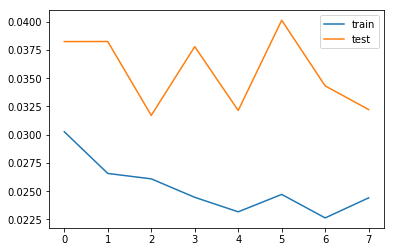

In [65]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X_val.shape[1], train_X_val.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=2, mode='auto')
# fit network
history = model.fit(train_X_val, train_y_val, epochs=20, batch_size=1000, validation_data=(test_X_val, test_y_val), verbose=2, shuffle=False, callbacks=[es])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [64]:
# make a prediction, however each new day must update the var(t-1) for the next day, which is e5gas(t-1)
# so we need to do this one day at a time
# also need to check the last day

yhat_days = {}
days = test_X['num_days'].unique()
gas_before = []
for index, day in enumerate(days):
    print(index, day)
    df = test_X.loc[test_X['num_days'] == day]
    if len(gas_before) > 0:
        df['lag_e5gas'] = gas_before

    test_X_day = df.values
    test_X_day = test_X_day.reshape((test_X_day.shape[0], 1, test_X_day.shape[1]))
    yhat = model.predict(test_X_day)
    yhat_days[index] = yhat
    gas_before = yhat

# convert yhat to numpy array
yhat = np.array([])
for key, value in yhat_days.items():
    yhat = np.append(yhat, value)

# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.4f' % rmse)

Test RMSE: 0.0452


* 50 neurons, 10 epochs, 7200 batch size, 1 layer (1): 0.032
* 50 neurons, 15 epochs, 7200 batch size, 1 layer (1): 0.032
* 50 neurons, 1 epochs, 7200 batch size, 1 layer (1): 0.032
* 50 neurons, 1 epochs, 1000 batch size, 1 layer (1): 0.034
* 50 neurons, 10 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 15 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 10 epochs, 1000 batch size, 2 layers (10,1): 0.037
* 50 neurons, 10 epochs, 3000 batch size, 1 layer (1): 0.032
* 50 neurons, 10 epochs, 900 batch size, 1 layer (1): 0.032
* 50 neurons, 10 epochs, 500 batch size, 1 layer (1): 0.33
* 50 neurons, 5 epochs, 1000 batch size, 1 layer (1): 0.33
* 50 neurons, 20 epochs, 1000 batch size, 1 layer (1): 0.030
* 50 neurons, 30 epochs, 1000 batch size, 1 layer (1): 0.030
* 50 neurons, 30 epochs, 10000 batch size, 1 layer (1): 0.036
* 50 neurons, 40 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 100 epochs, 1000 batch size, 1 layer (1): 0.032
* 50 neurons, 500 epochs, 1000 batch size, 1 layer (1):

Smaller data size:
* 50 neurons, 50 epochs, 1000 batch size, 1 layer (1): 0.031
* 50 neurons, 60 epochs, 1000 batch size, 1 layer (1): 0.032
* 50 neurons, 60 epochs, 500 batch size, 1 layer (1): 0.031
* 50 neurons, 70 epochs, 500 batch size, 1 layer (1): 0.031
* 50 neurons, 80 epochs, 500 batch size, 1 layer (1): 0.030
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1): 0.031

Early Stopping
SMALL
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1), 2 patience: 0.033
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1), 5 patience: 0.034
* 50 neurons, 90 epochs, 500 batch size, 1 layer (1), 20 patience: 0.036
* 50 neurons, 100 epochs, 500 batch size, 1 layer (1), 40 patience: 0.032
* 50 neurons, 100 epochs, 500 batch size, 1 layer (1), 50 patience: 0.030 (epoch 100)

FULL
* 50 neurons, 500 epochs, 1000 batch size, 1 layer (1), 5 patience: 0.30 (epoch 27)
* 50 neurons, 20 epochs, 1000 batch size, 1 layer (1), 5 patience: 0.30 (epoch 20)

Dropout

More Layers

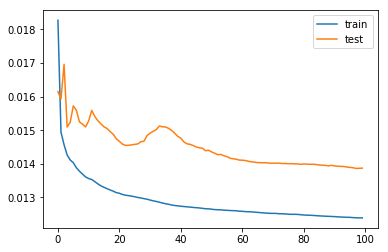

In [101]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [118]:
from bokeh.plotting import figure, output_file, show

output_file("line.html")

p = figure(plot_width=400, plot_height=400)
p.yaxis.axis_label = 'Root Mean Squared Error'
p.xaxis.axis_label = 'Epoch'

# add a line renderer
p.line(range(1,101), history.history['loss'], line_width=2, color='navy', legend='Train Loss')
p.line(range(1,101), history.history['val_loss'], line_width=2, color='orange', legend='Test Loss')

show(p)

/usr/local/anaconda3/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 100), ('y', 20)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
/usr/local/anaconda3/lib/python3.6/site-packages/bokeh/models/sources.py:137: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 100), ('y', 20)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


In [116]:
# small 100
best_y = inv_y
best_yhat = inv_yhat

In [119]:
# each day to make a graph of the error
ob = pd.DataFrame(inv_y)
pred = pd.DataFrame(inv_yhat)
pred[15] = round(pred[15])
pred[16] = round(pred[16])

In [120]:
rmse_days = []
days = []
for i in range(545,575):
    c_ob = ob[ob[16] == i][0]
    c_pred = pred[pred[16] == i][0]
    rmse_days.append(sqrt(mean_squared_error(c_ob, c_pred)))
    days.append(i)
    

In [121]:
rmse_days
days_df = pd.DataFrame()
days_df['rmse'] = rmse_days
days_df['date'] = last_30
days_df['date'] = pd.to_datetime(days_df['date'])

In [124]:
from bokeh.plotting import figure, output_file, show

output_file("line.html")

p = figure(plot_width=400, plot_height=400, x_axis_type='datetime')
p.yaxis.axis_label = 'Root Mean Squared Error'

# add a line renderer
p.line(days_df['date'], days_df['rmse'], line_width=2, color='#DD4968')

show(p)

In [43]:
test_X

,aral,autobahn,brent,dautobahn,esso,jet,lag_e5gas,latitude,longitude,num_days,...,state_8,state_9,total,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,wti
date,,,,,,,,,,,,,,,,,,,,,
2015-11-12,0,0,48.112483,14850.392578,0,0,1.327333,51.157501,10.00020,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,538.870667,0,1,1.302750,53.519798,10.00040,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,12108.902344,0,0,1.352750,48.894600,10.00050,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,270.597382,0,0,1.409417,49.911800,10.00180,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,3399.334473,0,0,1.394417,49.793301,10.00230,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,4232.930664,0,1,1.303583,53.660500,10.00230,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,6196.844727,0,0,1.319000,48.390800,10.00250,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,1,0,48.112483,8669.116211,0,0,1.362750,52.054298,10.00280,545,...,0,0,0,0,0,0,1,0,0,44.014304
2015-11-12,0,0,48.112483,3949.967041,0,0,1.314417,53.704899,10.00320,545,...,0,0,0,0,0,0,1,0,0,44.014304
